# Управление методом Монте-Карло. Исследовательские старты

Ричард С. Саттон, Эндрю Дж. Барто Обучение с подкреплением, 2020

In [24]:
import random

In [25]:
points = range(12, 22) # Текущая сумма очков от 12 до 21
dealer_card = [2, 3, 4, 5, 6, 7, 8, 9, 10, None] # Открытая карта диллера, Играющий туз - 10-й вариант
playing_ace = [0, 1] # Наличие играющего туза
states = [[i,j,k] for i in points
                for j in dealer_card 
                for k in playing_ace] # Состояния в итоге, должно получиться 200 состояний

In [26]:
len(states)

200

In [27]:
random.seed(555)

In [28]:
def get_card(cards, player_cards):
    i = random.randrange(len(cards))
    card = cards[i]
    del cards[i]
    if card is None:
        if sum(player_cards) == 11:
            card = 1
        else:
            card = 11
    player_cards.append(card)

In [29]:
def run_episode():
    # Список ходов - описание игры ("эпизода") см. Р. С. Саттон, Э. Д. Барто Обучение с подкреплением с. 125
    # Каждый элемент:
    # 1) S Состояние - строка '%сумма очков%%открытая карта сдающего%%наличие играющего туза%'
    # 2) А - действие 1 - еще, 0 - хватит
    # 3) R - вознагражение - на всех шагах кроме последнего 0, 1 если выигрыш, 0 если ничья, -1 если проигрыш
    episode = []

    # Собираем колоду
    cards = [2, 3, 4, 5, 6, 7, 8, 9, 10,
             None, # Туз
             10,   # Валет
             10,   # Дама
             10]   # Король
    cards = cards*4
    random.shuffle(cards)
    dealer_cards, player_cards, cards = cards[:2], cards[2:4], cards[4:]
    dealer_open_card = random.choice(dealer_cards)
    if_has_play_ace = 0

    # В начале партии разбираемся с играющими тузами
    if (dealer_cards[0] is None) and (dealer_cards[1] is None):
        dealer_cards[0] = 11
        dealer_cards[1] = 1
    else:
        if dealer_cards[0] is None:
            dealer_cards[0] = 11
        if dealer_cards[1] is None:
            dealer_cards[1] = 11

    if (player_cards[0] is None) and (player_cards[1] is None):
        player_cards[0] = 11
        player_cards[1] = 1
        if_has_play_ace = 1
    else:
        if player_cards[0] is None:
            player_cards[0] = 11
            if_has_play_ace = 1
        if player_cards[1] is None:
            player_cards[1] = 11
            if_has_play_ace = 1

    # Набираем до 12 так как счет суммы очков имеет смысл вести с 12
    while True:
        if sum(player_cards)>=12:
            break
        get_card(cards, player_cards)

    A = 1 # Текущее действие игрока
    R = 0 # Выигрыш всегда на каждом шаге 0 (кроме последнего)

    d_sum = sum(dealer_cards)
    p_sum = sum(player_cards)

    while True:
        if A == 1:
            # Добавляем ход в эпизод (игру)
            S = '|'.join([str(p_sum), str(dealer_open_card), str(if_has_play_ace)])
            episode.append([S,A,R])

        if A == 1:
            if ((d_sum == 21) and (p_sum == 21)):
                break
            if (d_sum == 21):
                episode[-1][2] = -1
                break
        elif A == 0:
            if (d_sum >= 17):
                if (d_sum > p_sum):
                    episode[-1][2] = -1
                    break
                if (d_sum < p_sum):
                    episode[-1][2] = 1
                    break
                if (d_sum == p_sum):
                    break
            else:
                if (d_sum > p_sum):
                    episode[-1][2] = -1
                    break

        # Ход игрока стратегия хватит или дальше
        if A == 1:
            A = random.choice([0, 1])

        if A == 1:
            get_card(cards, player_cards)
            p_sum = sum(player_cards)
            if p_sum > 21:
                episode[-1][2] = -1
                break

        if A == 0:
            get_card(cards, dealer_cards)  
            d_sum = sum(dealer_cards)
            if d_sum > 21:
                episode[-1][2] = 1
                break
    
    return episode

In [30]:
episodes = []
N = 2000000

In [31]:
for i in range(N):
    episodes.append(run_episode())

In [32]:
# Итоговые стратегии для состояний
strategies = {}
# Заполняем начальные стратегии
for points in range(12, 22):
    for open_card in [2, 3, 4, 5, 6, 7, 8, 9, 10, None]:
        for playing_ace in [0, 1]:
            S = '|'.join([str(points), str(open_card), str(playing_ace)])
            if points in (20, 21):
                strategies[S] = 0
            else:
                strategies[S] = 1

In [33]:
# Функции ценностей и Returns для всех пар состояние-действие
values, rets = {}, {}
# Заполняем начальные ценности и Returns
for points in range(12, 22):
    for open_card in [2, 3, 4, 5, 6, 7, 8, 9, 10, None]:
        for playing_ace in [0, 1]:
            S = '|'.join([str(points), str(open_card), str(playing_ace)])
            for action in [0, 1]:
                key = '|'.join([S, str(action)])
                values[key] = 0.0
                rets[key] = []

In [34]:
def avg_lst(lst):
    return sum(lst) / float(len(lst))

In [35]:
for episode in episodes:
    # МК метод первого посещения
    visited = []
    for step in episode:
        visited_key = ''.join([step[0], str(step[1]), str(step[2])])
        if visited_key in visited:
            continue
        visited.append(visited_key)
        key = '|'.join([step[0], str(step[1])])
        rets[key].append(step[2])
        values[key] = avg_lst(rets[key])
        
        # Выбор оптимальной стратегии
        sk1, sk0 = '|'.join([step[0],str(1)]), '|'.join([step[0],str(0)])
        
        if values[sk1] > values[sk0]:
            strategies[step[0]] = 1
        else:
            strategies[step[0]] = 0

In [36]:
strategies_ace_points = []
strategies_ace_dealer_card = []
strategies_actions = []
for k in strategies.keys():
    if_ace = int(k[-1])
    ind = k.find('|')
    points = int(k[:ind])
    ind2 = k.find('|',(ind+1))
    dealer_card = k[(ind+1):ind2]
    if dealer_card == 'None':
        dealer_card = 11
    else:
        dealer_card = int(dealer_card)
    if (if_ace == 1):
        strategies_ace_points.append(points)
        strategies_ace_dealer_card.append(dealer_card)
        strategies_actions.append(strategies[k])

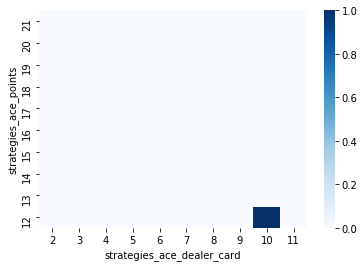

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.DataFrame(data={'strategies_ace_points':strategies_ace_points,
                          'strategies_ace_dealer_card':strategies_ace_dealer_card, 
                           'strategies_actions':strategies_actions})
data = data.pivot(columns='strategies_ace_dealer_card', index='strategies_ace_points', values='strategies_actions')
ax = sns.heatmap(data, cmap="Blues")
ax.invert_yaxis()

# Вторая версия

https://github.com/sgodwincs/blackjack-monte-carlo-es/blob/master/python/blackjack.py

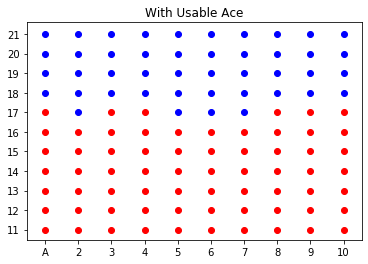

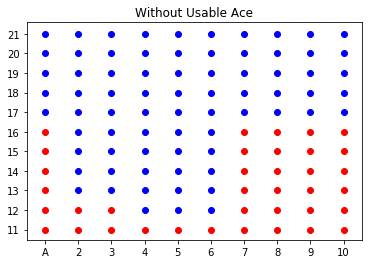

In [23]:
import numpy as np
import matplotlib.pyplot as plt

class Player(object):
    def __init__(self, currentSum, usableAce, dealersCard):
        self.currentSum = currentSum
        self.dealersCard = dealersCard
        self.usableAce = usableAce
        self.usingAce = self.usableAce

    def AddCard(self, card):
        if self.usingAce and self.currentSum + card > 21:
            self.usingAce = False
            self.currentSum += card - 10
        else:
            self.currentSum += card

    def Bust(self):
        return self.GetValue() > 21

    def GetState(self):
        return (self.currentSum, self.usableAce, self.dealersCard)

    def GetValue(self):
        return self.currentSum

    def ShouldHit(self, policyMap):
        return policyMap[self.GetState()]

class Dealer(object):
    def __init__(self, cards):
        self.cards = cards

    def AddCard(self, card):
        self.cards.append(card)

    def Bust(self):
        return self.GetValue() > 21

    def GetValue(self):
        currentSum = 0
        aceCount = 0

        for card in self.cards:
            if card == 1:
                aceCount += 1
            else:
                currentSum += card

        while aceCount > 0:
            aceCount -= 1
            currentSum += 11

            if currentSum > 21:
                aceCount += 1
                currentSum -= 11
                currentSum += aceCount
                break

        return currentSum

    def ShouldHit(self):
        if self.GetValue() >= 17:
            return False
        else:
            return True

class StateActionInfo(object):
    def __init__(self):
        self.stateActionPairs = [ ]
        self.stateActionMap = set()

    def AddPair(self, pair):
        if pair in self.stateActionMap:
            return

        self.stateActionPairs.append(pair)
        self.stateActionMap.add(pair)

def EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionPairs, reward):
    for pair in stateActionPairs:
        returns[pair] += 1
        actionValueMap[pair] = actionValueMap[pair] + ((reward - actionValueMap[pair]) / returns[pair])

        state = pair[0]
        shouldHit = False

        if actionValueMap[(state, True)] > actionValueMap[(state, False)]:
            shouldHit = True

        policyMap[state] = shouldHit

def GenerateCard():
    card = np.random.randint(1, 14)

    if card > 9:
        return 10
    else:
        return card

def GenerateStart(actionValueMap, policyMap, returns):
    playerSum = np.random.randint(11, 22)
    usableAce = bool(np.random.randint(0, 2))
    dealersCard1 = np.random.randint(1, 11)

    player = Player(playerSum, usableAce, dealersCard1)
    dealer = Dealer([ dealersCard1 ])

    stateActionInfo = StateActionInfo()
    shouldHit = bool(np.random.randint(0, 2))
    stateActionInfo.AddPair((player.GetState(), shouldHit))

    if shouldHit:
        player.AddCard(GenerateCard())

        while not player.Bust() and player.ShouldHit(policyMap):
            stateActionInfo.AddPair((player.GetState(), True))
            player.AddCard(GenerateCard())

    if player.Bust():
        EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionInfo.stateActionPairs, -1)
        return

    stateActionInfo.AddPair((player.GetState(), False))
    dealer.AddCard(GenerateCard())

    while not dealer.Bust() and dealer.ShouldHit():
        dealer.cards.append(GenerateCard())

    if dealer.Bust() or dealer.GetValue() < player.GetValue():
        EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionInfo.stateActionPairs, 1)
    elif dealer.GetValue() > player.GetValue():
        EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionInfo.stateActionPairs, -1)
    else:
        EvaluateAndImprovePolicy(actionValueMap, policyMap, returns, stateActionInfo.stateActionPairs, 0)


def PerformMonteCarloES():
    actionValueMap = { }
    policyMap = { }
    returns = { }

    for playerSum in range(11, 22):
        for usableAce in range(2):
            for dealersCard in range(1, 11):
                playerState = (playerSum, bool(usableAce), dealersCard)
                actionValueMap[(playerState, False)] = 0
                actionValueMap[(playerState, True)] = 0
                returns[(playerState, False)] = 0
                returns[(playerState, True)] = 0

                if playerSum == 20 or playerSum == 21:
                    policyMap[playerState] = False
                else:
                    policyMap[playerState] = True

    for i in range(2000000):
        GenerateStart(actionValueMap, policyMap, returns)

    x11 = [ ]
    y11 = [ ]

    x12 = [ ]
    y12 = [ ]

    x21 = [ ]
    y21 = [ ]

    x22 = [ ]
    y22 = [ ]

    for playerState in policyMap:
        if playerState[1]:
            if policyMap[playerState]:
                x11.append(playerState[2] - 1)
                y11.append(playerState[0] - 11)
            else:
                x12.append(playerState[2] - 1)
                y12.append(playerState[0] - 11)
        else:
            if policyMap[playerState]:
                x21.append(playerState[2] - 1)
                y21.append(playerState[0] - 11)
            else:
                x22.append(playerState[2] - 1)
                y22.append(playerState[0] - 11)

    plt.figure(0)
    plt.title('With Usable Ace')
    plt.scatter(x11, y11, color='red')
    plt.scatter(x12, y12, color='blue')
    plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
    plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

    plt.figure(1)
    plt.title('Without Usable Ace')
    plt.scatter(x21, y21, color='red')
    plt.scatter(x22, y22, color='blue')
    plt.xticks(range(10), [ 'A', '2', '3', '4', '5', '6', '7', '8', '9', '10' ])
    plt.yticks(range(11), [ '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21' ])

    plt.show()

PerformMonteCarloES()

![monte_carlo_optimal_policy.png](./img/monte_carlo_optimal_policy.png)